In [1]:
import os
os.chdir("..")

import pathpy as pp
from pathpy import Network
import matplotlib.pyplot as plt
import networkx as nx

from typing import TYPE_CHECKING, Dict, List, Tuple, Union, Any
import scipy as sp
from scipy.sparse import linalg as spl
import numpy as np

from collections import defaultdict # think these two are used to iterate through dicts
from collections.abc import Iterable
from __future__ import annotations
from typing import TYPE_CHECKING, Union, Dict, Tuple

import my_functions

## Import some data

In [256]:
    # from paths dataset - 1% sample to start
    flight_paths= pp.Paths.read_file("Data/US flights 2011/US flights od.ngram", separator=',', frequency=True)
    flights = pp.Network.from_paths(flight_paths)
    #m2 = pp.HigherOrderNetwork(flight_paths, k=2)
    
    
    # from paths dataset - use this instead
    tube_paths = pp.Paths.read_file("Data/Tube/tube_paths_train.ngram", separator=',', frequency=True)
    tubes = pp.Network.from_paths(tube_paths)
    #m1 = pp.HigherOrderNetwork(tube_paths, k=2)
    
    # from taxi dataset
    # from paths dataset - use this instead
    taxi_paths = pp.Paths.read_file("Data/SF taxis/Sf taxis od.ngram", separator=',', frequency=True)
    taxis = pp.Network.from_paths(taxi_paths)
    

2021-04-25 17:03:31 [Severity.INFO]	Reading ngram data ... 
2021-04-25 17:03:31 [Severity.INFO]	finished. Read 358 paths with maximum length 7
2021-04-25 17:03:31 [Severity.INFO]	Calculating sub path statistics ... 
2021-04-25 17:03:31 [Severity.INFO]	finished.
2021-04-25 17:03:31 [Severity.INFO]	Reading ngram data ... 
2021-04-25 17:03:32 [Severity.INFO]	finished. Read 61748 paths with maximum length 35
2021-04-25 17:03:32 [Severity.INFO]	Calculating sub path statistics ... 
2021-04-25 17:03:38 [Severity.INFO]	finished.
2021-04-25 17:03:38 [Severity.INFO]	Reading ngram data ... 
2021-04-25 17:03:38 [Severity.INFO]	finished. Read 53 paths with maximum length 20
2021-04-25 17:03:38 [Severity.INFO]	Calculating sub path statistics ... 
2021-04-25 17:03:38 [Severity.INFO]	finished.


In [257]:
def get_stationary(T):
    '''will get the left eigenvector corresponding to eigenvalue 1 and return it normalised'''
    # np.linalg.eig finds right eigenvectors - code from a very helpful stack exchange
    # https://stackoverflow.com/questions/31791728/python-code-explanation-for-stationary-distribution-of-a-markov-chain?fbclid=IwAR0YnlQ7iwr1Ve1kRn-b6CDT0rbq7lDdBM1oD_KwiaEODWPv_-GMwiGBcVw
    evals, evecs = np.linalg.eig(T.T)
    evec1 = evecs[:,np.isclose(evals, 1)]
    evec1 = evec1[:,0]
    stationary = evec1 / evec1.sum()
    stationary = stationary.real
    stationary = np.squeeze(np.asarray(stationary))
    return stationary

def transition_mat(net,method="smart",alpha=0.85):
    '''modified from pathpy pagerank code, transition matrix with teleportation
    this will slow down computation as matrices will no longer be sparse'''
    
    N = net.ncount()
    I = sp.sparse.identity(N)
    A = net.adjacency_matrix()

    # row sums are out-degrees for adjacency matrix
    row_sums = np.array(A.sum(axis=1)).flatten()

    # replace non-zero entries x by 1/x
    row_sums[row_sums != 0] = 1.0 / row_sums[row_sums != 0]

    # indices of zero entries in row_sums
    b = list(np.where(row_sums != 0)[0])
    d = list(np.where(row_sums == 0)[0])

    # create sparse matrix with row_sums as diagonal elements
    Dinv = sp.sparse.spdiags(row_sums.T, 0, A.shape[0], A.shape[1],
                               format='csr')

    # with this, we have divided elements in non-zero rows in A by 1 over the row sum
    T = Dinv * A
    
    if method == "smart":
        # calculate preference vector using node in-strengths
        w_in = np.array(net.node_properties("inweight"))
        W = sum(w_in)
        v = w_in/W 
    elif method == "standard":
        v = np.ones(N)/N
    
    # replace nonzero rows with alpha*T + (1-alpha)*u
    for ib in b: T[ib,:] = alpha*T[ib,:] + (1-alpha)*v
        
    # replace all fully zero rows with v 
    for id in d: T[id,:] = v
    
    return T.todense()


def Laplacian_mat(net,alpha=0.85):
    '''random walk-normalised Laplacian with smart recorded teleportation: fix this to match papers and check applicability'''
    N = net.ncount()
    I = np.eye(N)
    T = transition_mat(net)
    
    Lrw = I - T 
    
    return Lrw

def my_pagerank(net,alpha=0.85,method = "smart"):
    '''Needs to be imporoved to be more efficient but does the job right now
    slightly modified.'''
    
    pr = defaultdict(lambda: 0)
    
    # adjacency matrix where Aij s.t. i->j
    I = sp.sparse.identity(net.ncount())
    A = m1.adjacency_matrix()
    T = transition_mat(net)
    
    #v11 = -1
    #spectral_gap=-1
    #while v11<0:
     #   _,ps = sp.sparse.linalg.eigs(T,k=1,which='LM',tol=0) # check L&R
     #   ps_t = ps.real
     #   v11 = ps_t[0]
    
    # old PageRank stuff (doesn't quite agree with Laplacians)
    # calculate preference vector using node in-strengths
    #w_in = np.array(net.node_properties("inweight"))
    #W = sum(w_in)
    #v = w_in/W 
    #T_alpinv = sp.sparse.linalg.inv(I-alpha*T) # define inverse of (1-alpha*T)
    #p_rank = (1-alpha)*T_alpinv.dot(v)
    
    # add one additional step for unrecorded - do this later
    #if method == "unrecorded":
    #    p_rank = T.dot(p_rank)
    
    pr = get_stationary(T)
    
    pr = dict(zip(net.nodes, map(float, pr)))
    
    return pr

## Check T properties

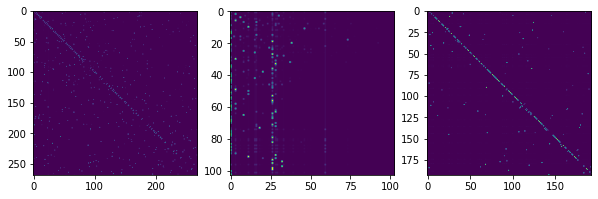

In [320]:
T_tubes = transition_mat(tubes)
T_flights = transition_mat(flights)
T_taxis = transition_mat(taxis)

fig, ax = plt.subplots(1,3, figsize = (10,10))

ax[0].imshow(T_tube)
ax[1].imshow(T_flights)
ax[2].imshow(T_taxis)

In [271]:
pi_tubes = np.array(list(my_pagerank(tubes).values()))
pi_flights = np.array(list(my_pagerank(flights).values()))
pi_taxis = np.array(list(my_pagerank(taxis).values()))

# Setting up basic tools
Need Laplacian, transition matrix and adjacency matrix for weighted, directed network
Make sure: ergodic and $T$ a stochastic matrix $\implies T1 = 1$
Remove hanging nodes to make graph ergodic. Need to make strongly connected overlay tbh.

In [294]:
# all the tools for similarity matrix construction
N = m1.ncount()
col_ones = np.ones((N,1))

# out-strength matrix
out_strengths = np.array(m1.node_properties('outweight'))
D_out = sp.sparse.diags(out_strengths)

# adjacency matrices
A_flights = flights.adjacency_matrix()
A_tubes = tubes.adjacency_matrix()
A_taxis = taxis.adjacency_matrix()

# Random walk-normalised Laplacians
Lrw_flights = Laplacian_mat(flights) 
Lrw_tubes = Laplacian_mat(tubes) 
Lrw_taxis = Laplacian_mat(taxis) 


Text(0.5, 1.0, 'Taxis adjacency matrix')

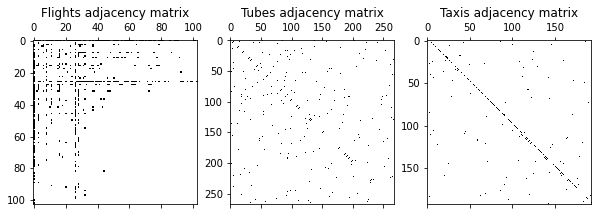

In [316]:
fig, ax = plt.subplots(1,3,figsize=(10,10))

im1 = ax[0].spy(A_flights.todense())
ax[0].set_title("Flights adjacency matrix")
im2 = ax[1].spy(A_tubes.todense())
ax[1].set_title("Tubes adjacency matrix")
im3 = ax[2].spy(A_taxis.todense())
ax[2].set_title("Taxis adjacency matrix")


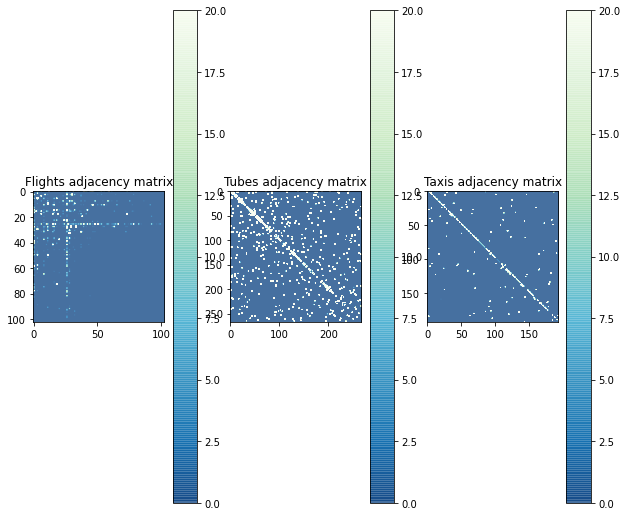

In [309]:
fig, ax = plt.subplots(1,3,figsize=(10,10))

im1 = ax[0].imshow(A_flights.todense(),clim=(0,20),cmap="GnBu_r",alpha=0.75)
ax[0].set_title("Flights adjacency matrix")
im2 = ax[1].imshow(A_tubes.todense(),clim=(0,20),cmap="GnBu_r",alpha=0.75)
ax[1].set_title("Tubes adjacency matrix")
im3 = ax[2].imshow(A_taxis.todense(),clim=(0,20),cmap="GnBu_r",alpha=0.75)
ax[2].set_title("Taxis adjacency matrix")

fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
fig.colorbar(im3, ax=ax[2])

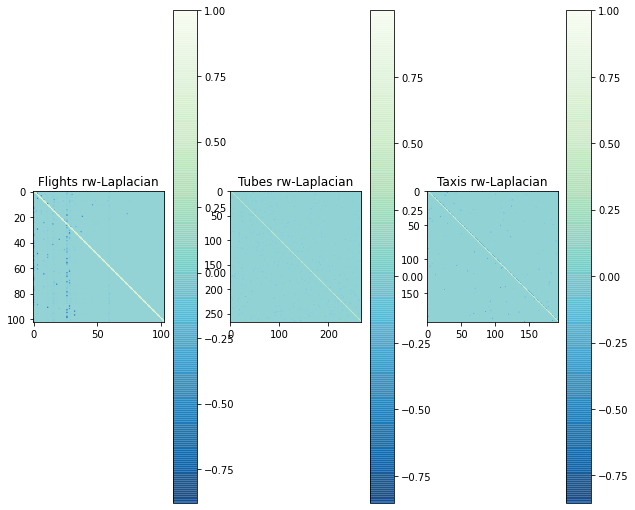

In [310]:
fig, ax = plt.subplots(1,3,figsize=(10,10))

im1 = ax[0].imshow(Lrw_flights,cmap="GnBu_r",alpha=0.75)
ax[0].set_title("Flights rw-Laplacian")
im2 = ax[1].imshow(Lrw_tubes,cmap="GnBu_r",alpha=0.75)
ax[1].set_title("Tubes rw-Laplacian")
im3 = ax[2].imshow(Lrw_taxis,cmap="GnBu_r",alpha=0.75)
ax[2].set_title("Taxis rw-Laplacian")


fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
fig.colorbar(im3, ax=ax[2])

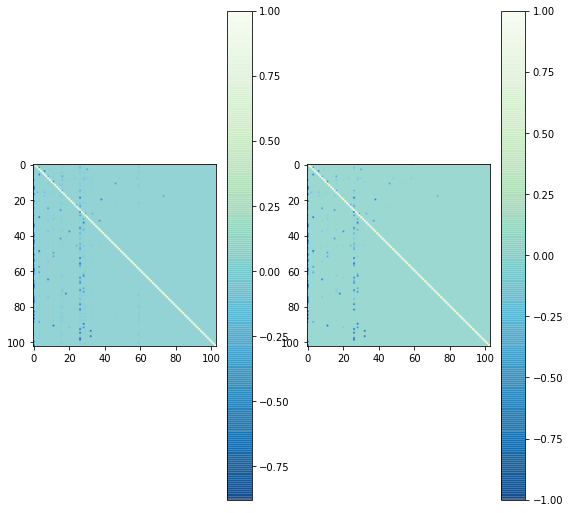

In [313]:
# compare smart Laplacian with pathpy - looks similar

fig,ax=plt.subplots(1,2,figsize=(9,9))

im1 = ax[0].imshow(Laplacian_mat(flights),cmap="GnBu_r",alpha=0.75)
im2 = ax[1].imshow(np.eye(N)- flights.transition_matrix().transpose().todense(),cmap="GnBu_r",alpha=0.75)

fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])

# Basic DTRW-based similarity matrices

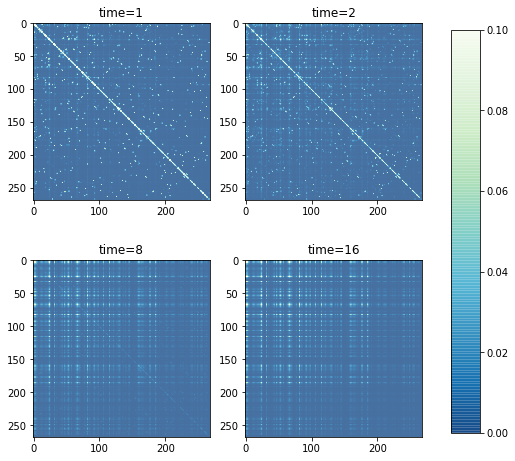

In [323]:
T = T_tubes

fig, ax = plt.subplots(2,2,figsize=(8,8))

im = ax[0,0].imshow((T.T @ T),clim=(0,0.1),cmap="GnBu_r",alpha=0.75)
im = ax[0,1].imshow(((T.T**2) @ T**2),clim=(0,0.1),cmap="GnBu_r",alpha=0.75)
im = ax[1,0].imshow(((T**8).T @ T**8),clim=(0,0.1),cmap="GnBu_r",alpha=0.75)
im = ax[1,1].imshow(((T**16).T @ T**16),clim=(0,0.1),cmap="GnBu_r",alpha=0.75)

ax[0,0].set_title("time={}".format(1))
ax[0,1].set_title("time={}".format(2))
ax[1,0].set_title("time={}".format(8))
ax[1,1].set_title("time={}".format(16))


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)


## Dynamical similarity

In [423]:
# choose network to examine
net = taxis
Lrw = Lrw_taxis
N = taxis.ncount()
pi_t = pi_taxis
T = T_taxis

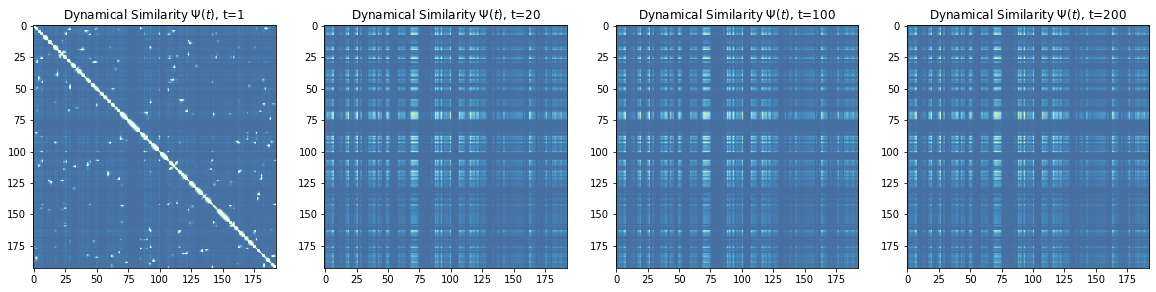

In [399]:
# unweighted first: time=t
# tidy up colorbars later; https://joseph-long.com/writing/colorbars/ 

I = sp.sparse.identity(N)
times = [1,20,100,200]
fig,ax = plt.subplots(1,4,figsize=(20,20))

i=0
for t in times:
    Y = spl.expm(-Lrw * t)
    Psi = Y.T @ Y
    imx = ax[i].imshow(Psi,clim=(0,0.1),cmap="GnBu_r",alpha=0.75)
    ax[i].set_title(r'Dynamical Similarity $\Psi(t)$, t='+str(t))
    #plt.colorbar(im=imx,ax=ax[i])
    i = i+1

Text(0.5, 1.0, 'outer product $\\pi^T\\pi$')

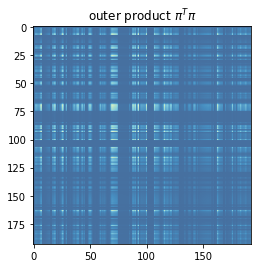

In [407]:
# check what dimension of pattern comes from stationarity distribution / null model
plt.imshow(sp.sparse.csr_matrix(np.outer(pi_t,pi_t)).todense(),cmap="GnBu_r",alpha=0.75)
plt.title("outer product $\pi^T\pi$")

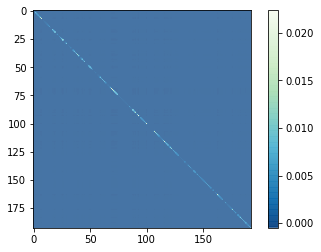

In [408]:
# construct weighting matrix Sigma to project away stationary distribution
Pi = sp.sparse.diags(pi_t).todense()
Sigma_0 = Pi - sp.sparse.csr_matrix(np.outer(pi_t,pi_t)).todense()
plt.imshow(Sigma_0,cmap="GnBu_r",alpha=0.75)
plt.colorbar()

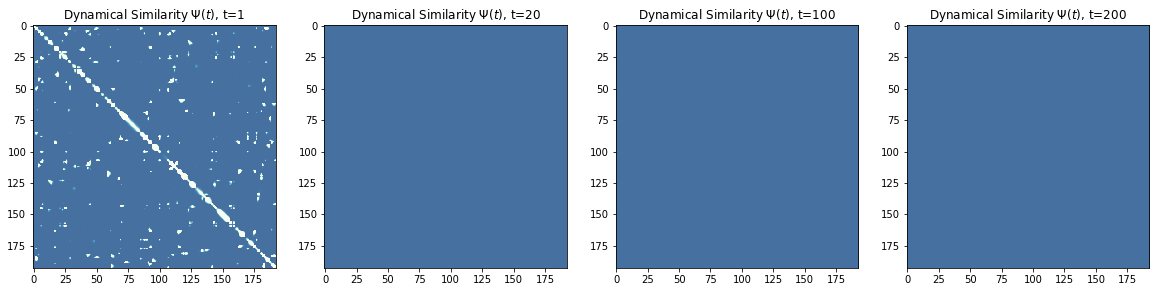

In [419]:
fig,ax = plt.subplots(1,4,figsize=(20,20))

i=0
for t in times:
    Y = spl.expm(-Lrw * t)
    Psi = Y.T @ Sigma_0 @ Y
    imx = ax[i].imshow(Psi,clim=(0,1e-4),cmap="GnBu_r",alpha=0.75)
    ax[i].set_title(r'Dynamical Similarity $\Psi(t)$, t='+str(t))
    i = i+1


# Markov Stability
Not too sure about choice of teleporting Laplacian here tbh (think there should be an alpha?)

# Walktrap

In [437]:
def walktrap_similarity(net, n=None):
    
    if n==None:
        # choose a number of steps
        if pp.algorithms.shortest_paths.diameter(net) == np.inf:
            n = net.ncount()
        else:
            n = np.ceil((pp.algorithms.shortest_paths.diameter(net)))
            
            
    # transiton matrix  
    T = transition_mat(net)
    
    # stationary distribution
    pi_t = np.array(list(my_pagerank(net).values()))
    
    # construct null model
    Pi = sp.sparse.diags(pi_t).todense()
        
    W = Pi
    Tn = T**n
    Psi_Wt = (Tn.T @ W @ Tn)
    
    return Psi_Wt

In [448]:
    Y = spl.expm(-Lrw * t)
    Psi = Y.T @ Sigma_0 @ Y
    imx = ax[i].imshow(Psi,clim=(0,1e-4),cmap="GnBu_r",alpha=0.75)
    ax[i].set_title(r'Dynamical Similarity $\Psi(t)$, t='+str(t))
    i = i+1

193

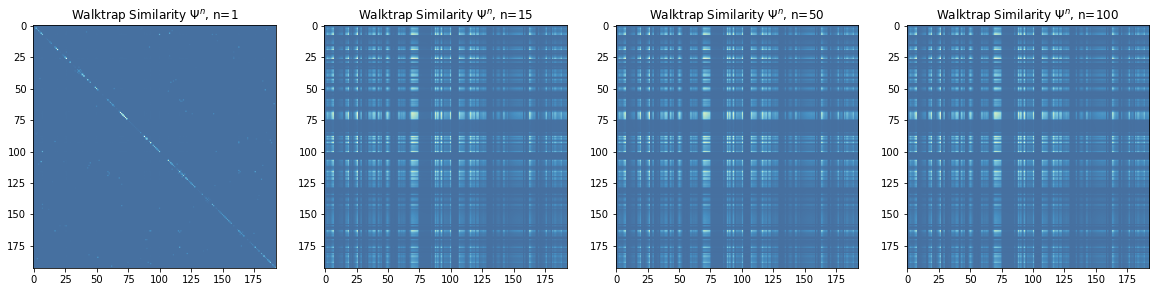

In [464]:
steps = [1,15,50,100]
fig,ax = plt.subplots(1,4,figsize=(20,20))

i=0
for n in steps:
    Psi_Wt = walktrap_similarity(taxis,n=n)
    ax[i].imshow(Psi_Wt,cmap="GnBu_r",alpha=0.75)
    ax[i].set_title(r'Walktrap Similarity $\Psi^n$, n='+str(n))
    i = i+1

In [ ]:
steps = []

# Community detection via optimising similarity matrices
Louvain algortihm (embedding paper)

In [69]:
def quality_func(Psi,H):
    R = np.trace((H.T @ Psi @ H).todense())
    return R

In [208]:
Psi = Psi_wt

In [70]:
#initial random module assignments
N = m1.ncount()
H = np.eye(N, N) # identity should be fine
H = sp.sparse.csr_matrix(H)
Hj = H

# phase 1
k = 1
while k > 0:
    
    k = 0
    for i in range(0,N):

        jopt = np.where(H[i,:].todense()==1)[0][0]
        Rj = quality_func(Psi,H)

        for j in range(0,N):

            ej = np.zeros(N)
            ej[j] = 1.0
            Hj[i,:] = ej
            R = quality_func(Psi,Hj)

            if R > Rj:
                Rj = R
                jopt = j
                k = k+1 # record that a node has moved community
        
        H = Hj

Nc = np.count_nonzero(H.todense().sum(axis=0))
#If N > Nc:
    # drop all zero columns
    # assign each node a community C based off index of reduced column H
    # plot network with color-coded entries
    

ValueError: dimension mismatch

# Core-periphery for $\mathcal{M}_1$ network
Quite helpful: https://github.com/IngoScholtes/kdd2018-tutorial/blob/master/solutions/1_2_pathpy.py <br>
For directed and weighted networks. But needs to be connected because uses stationary distributions. For now take reduced connected network and look at teleportation later if possible. <br>
Node strength $s_i$ is the sum of the weights of the links connected to that node
1. Start at the node with the minimum total node strength $s^{in}_i+s^{out}_i$ and set $S=v_i$
2. Add a node to $S$ such that it creates the smallest increase in persistence probability \begin{equation}
\alpha_S = \frac{\sum_{i,j \in S}p_i^*T_{ij} }{\sum_{i \in S}p_i^*}
\end{equation}
3. Then the $\alpha$-periphery is the set of nodes $S_{\alpha}$ satisfying $\alpha_i \leq \alpha$ and you can tune by $\alpha$
Choose uniformly if you get have multiple nodes with the same strength etc <br> <br>

    functions moved to my_functions module

# Core-periphery for $\mathcal{M}_2$ network

## adapted

In [4]:
def get_node_strengths_m2(net):
    inw_list = list(zip(*net.node_properties('inweight')))[0]
    outw_list = list(zip(*net.node_properties('outweight')))[0]
    strengths = np.array(inw_list) + np.array(outw_list)
    return strengths

def remove_hanging_m2(net,method="cut"):
    '''Remove hanging nodes and returns network, need to this becuase otherwise the transition matrix
    T will be ill-defined'''
    if method == "teleport":
        return "no method defined for this yet"
    
    elif method == "cut":
        out_degrees = np.array(net.node_properties('outdegree'))
        
        if (out_degrees == 0).any():
            ind = np.where(out_degrees == 0)[0] 
            hanging_nodes = []
            for i in ind: hanging_nodes.append(list(net.nodes.keys())[i])
            for node in hanging_nodes : net.remove_node(node)
            
        return net
    
    else:
        return "no method defined for this"
    
def alpha_S(ind, T_t, ps_t):
    '''Calculate the persistence probability of a set of nodes S 
    ind : list of indices
    T_t : sparse transposed transition matrix
    ps_t = stationary probability column vector'''
    T_t = T_t[ind,:][:,ind]
    ps_t = ps_t[ind]
    return T_t.dot(ps_t).sum()/ps_t.sum()

## in progress

In [5]:
net = m2

In [14]:
net = remove_hanging_m2(net)
print(net.ecount())

336


In [15]:
A = net.adjacency_matrix(weighted=True)
T_t = net.transition_matrix()
T = T_t.transpose()
N = np.shape(A)[0]

out_degrees = np.array(net.node_properties('outdegree'))
node_strengths = get_node_strengths_m2(net) # problematic
assert ((out_degrees > 0).all()), "Network must be ergodic."




In [16]:
net

In [17]:
# get stationary distribution of first-order Markov process
# https://stackoverflow.com/questions/30966881/python-sp-sparse-linalg-eigs-giving-different-results-for-consecutive-calls
# Implicitly Restarted Arnoldi Method: occasionally gives negative results???
# it sometimes identifies the Fiedler vector as dominant eigenvector which means spectral gap must be small
# make statement that is lambda_1>lambda_2 then rerun
v11 = -1
while v11 < 0:
    _,ps = sp.sparse.linalg.eigs(T,k=1,which='LM',tol=1e-6,maxiter=N*100) # check L&R
    ps_t = ps.real
    v11 = ps_t[0]
    #fiedler_vec = evecs[:,1].real
    #spectral_gap = lambda_1-lambda_2
    


In [18]:
# get indices for node names (quick fix for now)
nodes_ind = np.arange(0,N)
node_dict = {}
coreness = {}
i=0
for node in net.nodes.keys():
    node_dict.update({i:node})
    coreness.update({node:0.0}) # initialise to zero
    i=i+1

In [19]:
# single run
#print(r/R)
# calculate node strengths
i_min = np.where(node_strengths == node_strengths.min())[0] 
i_min = np.random.choice(i_min,1)[0] # randomly choose one if there's multiple mins
coreness[node_dict[i_min]] = coreness[node_dict[i_min]] + 0.0
s0 = list(net.nodes.keys())[i_min] # node to initalise CP algorithm

# (greedy) algorithm to test which node will create smallest increase in alpha_S
S = [i_min]
alpha = alpha_S(S,T_t,ps_t) # alpha_S is zero for any single node
nodes = np.delete(nodes_ind,i_min)

while (len(nodes)>0):
    alpha_test = np.empty(N)
    alpha_test[:] = np.nan

    # calculate alpha increase for each node
    for node in nodes:
        S_test = S + [node]
        alpha_test[node] = alpha_S(S_test,T_t,ps_t) 

    # choose minimum alpha for this step
    node_min = np.where(alpha_test == np.nanmin(alpha_test))[0] 
    node_min = np.random.choice(node_min,1)[0]
    alpha = alpha + alpha_test[node_min]
    coreness[node_dict[node_min]] = coreness[node_dict[node_min]] + alpha_test[node_min]

    S = S + [node_min]
    nodes = nodes[nodes!=node_min]

In [20]:
for node, val in coreness.items():
        net.nodes[node]['coreness']=val

In [21]:
my_functions.print_coreness(net,coreness)

In [28]:
m2.nodes

coreness_map = {}
for m2_node in m2.nodes.keys():
    coreness_map.update({m2_node[0:3]:coreness[m2_node]})

In [30]:
for node, val in coreness_map.items():
    m1.nodes[node]['coreness']=val

In [38]:
coreness_map

{'DEN': 0.0,
 'AUS': 0.0200085230629285,
 'BOI': 0.0,
 'LAX': 0.0,
 'LIH': 0.0,
 'KOA': 0.0,
 'MCO': 0.45884984517047805,
 'CLE': 0.0,
 'SFO': 0.0,
 'LGA': 0.0,
 'ORD': 0.0,
 'PHX': 0.0,
 'SLC': 0.14161107191994363,
 'SBP': 0.15290567697787963,
 'MSP': 0.0,
 'SAN': 0.8200631471179638,
 'HNL': 0.0003548946438547728,
 'EGE': 0.0,
 'BOS': 0.0,
 'ELP': 0.0,
 'PDX': 0.13585006842146813,
 'SEA': 0.0,
 'PHL': 0.6328981949478474,
 'OGG': 0.0,
 'ATL': 0.0,
 'SNA': 0.0,
 'PSC': 0.09959201790885412,
 'SJC': 0.363105321731264,
 'GEG': 0.15844225005219775,
 'OAK': 0.0,
 'CLD': 0.0,
 'RNO': 0.0,
 'BZN': 0.0,
 'IAH': 0.0,
 'DTW': 0.0,
 'RDM': 0.0,
 'SBA': 0.32547554287535624,
 'IAD': 0.0,
 'SMF': 0.0,
 'CVG': 0.0,
 'ONT': 0.0,
 'JFK': 0.0,
 'MSY': 0.14729577235656519,
 'MMH': 0.0,
 'PIT': 0.0,
 'STL': 0.0,
 'TUS': 0.0,
 'BWI': 0.0,
 'LAS': 0.0,
 'MIA': 0.0,
 'LGB': 0.0,
 'EWR': 0.0,
 'SAT': 0.0,
 'BUR': 0.31579621053064044,
 'PSP': 0.0,
 'MRY': 0.0,
 'CLT': 0.0,
 'BNA': 0.0,
 'DAL': 0.003697648890060

In [36]:
alpha_c=1e-3
col1='lightskyblue'
col2='darkorange'
style={}
style['node_color']={v:col1 if u < alpha_c else col2 for v,u in coreness_map.items()}
style['force_charge']={v: -20 if u<alpha_c else -20 for v,u in coreness_map.items()}
pp.visualisation.plot(m1, **style)

    # to check T working as it should 
    ones = np.ones(4) # generalise to get size automatically later
    ones
    T.dot(ones) # check this is satisfied => should have an eigenvalue unity now
    
    # laplacian for later
    L = net.laplacian_matrix(weighted=True)
    Ldense = L.todense()

# Centrality functions

In [2]:
## from pathpy repo

def eigenvector_centrality(network: Network, # arg name and type (didn't know you could do this)
                           weight: Union[str, bool, None] = None,
                           alpha=0.85,
                           **kwargs: Any) -> dict:
    """Calculates the eigenvector centrality of all nodes.

    Parameters
    ----------
    network : Network

        The :py:class:`Network` object that contains the network

    Examples
    --------
    Compute eigenvector centrality in a simple network

    >>> import pathpy as pp
    >>> net = pp.Network(directed=True)
    >>> net.add_edge('a', 'x')
    >>> net.add_edge('x', 'b')
    >>> c = pp.algorithms.centralities.eigenvector_centrality(net)
    >>> c['a']
    1
    """
    evcent: dict = dict()
        
    A = network.adjacency_matrix(weighted=True, transposed=True) # changed this for my version
    N = A.shape[0] # total nodes
    I = sp.sparse.identity(N) # identity
    ev = spl.inv(I - alpha*A).dot(ones)
    
    if kwargs:
        _, ev = spl.eigs(A, k=1, which='LM', **kwargs) # which='LM' means find biggest, kwargs if changing eigenvec to test
    else:
        _, ev = spl.eigs(A, k=1, which='LM') # only returns vec for stationary distributino
    ev = ev.reshape(ev.size, ) # makes it a column vector I think
    S = np.sum(ev)
    
    for v, deg in network.nodes.items():
        evcent[v] = np.real(ev[network.nodes.index[v.uid]]/S) 
    for v in network.nodes:
        evcent[v.uid] = np.real(ev[network.nodes.index[v.uid]]/S) 
    return evcent


# so last few lines: take eigenvector corresponding to largest eigenvalue (1) of adjacency matrix of net
# reshape this vector to a column(?) vector. evcent is an empty dictionary. Then define for each key 1.uid 
# (not sure what uid stands for...) the values is the real part of the stationary probability averaged over 
# all the stationary probabilities and these will always sum to 1

## Trying to come generalise PageRank like in $(181)$

\begin{equation}
p^* = \frac{1-\alpha}{N}\begin{pmatrix}1 & ... & 1 \end{pmatrix} \begin{pmatrix} I - \alpha T \end{pmatrix}^{-1}
\end{equation}

My main issues are keeping it efficient, use sp.sparse etc. and also keeping track of the indices...except now that I think about it all that matters are the indices of $p^*=(p_1^*...p_N^*)$ so it's ok. <br><br>
T is defined wrong here, it is meant to be $T_{ij} = \frac{A_{ij}}{k_i^{\text{out}}}$., just going to assume $A_{ij}$ defines a path from $i \to j$ but might need to change this. Hence each row will need to be divide by it's sum to get $T$.

In [169]:

def my_pagerank(network,alpha = 0.85):

    node_names = list(network.nodes.keys())

    A = network.adjacency_matrix(weighted=True, transposed=False) # unsure about transpose
    N = A.shape[0] # total nodes
    I = sp.sparse.identity(N) # identity
    ones = np.ones(N)
    Ap = spl.inv(I - alpha*A)
    ev = (1-alpha)*Ap.dot(ones)/N
    S = sum(ev)
    ev = ev/S # normalised for some reason - might not be correct I need to check
    evcents = list(zip(node_names, zip(ev)))
    
    return evcents

I should be looking at PageRank because that's for directed networks (https://stats.stackexchange.com/questions/176874/pagerank-vs-eigenvector-centrality) PageRank uses in-degree of nodes specifically so is a special case of eigenvector centrality.

In [168]:
A = network.adjacency_matrix(weighted=True, transposed=False) # unsure about transpose
print(A)

  (0, 1)	1.0
  (0, 3)	1.0
  (1, 2)	1.0
  (3, 1)	1.0


In [197]:
out_deg = A.sum(1)
out_deg = np.squeeze(np.asarray(out_deg))

In [200]:
print(A)

  (0, 1)	1.0
  (0, 3)	1.0
  (1, 2)	1.0
  (3, 1)	1.0


In [201]:
out_deg = sp.sparse.spdiags(out_deg, 0, out_deg.size, out_deg.size)
out_deg.dot(A)

/usr/local/lib/python3.9/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


TypeError: no supported conversion for types: (dtype('O'),)

In [165]:
network

In [164]:
my_pagerank(network)

[('a', (0.4674229310154322,)),
 ('x', (0.1816998760021117,)),
 ('b', (0.09821614919033063,)),
 ('c', (0.25266104379212556,))]

In [160]:
pp.algorithms.centralities.pagerank(network)

{'a': 0.12045209234069676,
 'x': 0.3175410567582492,
 'b': 0.39036291569760717,
 'c': 0.1716439352034471}

My calculated results are different to the results of the PageRank function, but which is more accurate? <br>
Neither perform very well tbh. It's clear that b's centrality is too high because it has no out-degree ( can't see function so don't know if that transition matrix has been set up yet, I must fix that actually).

In [162]:
network

In [94]:
A = net.adjacency_matrix()
print(A)

  (0, 1)	1.0
  (1, 2)	1.0


In [19]:
at = a.reshape(a.size,)
at

array([ 0.00000000e+000, -2.68678569e+154,  1.48219694e-323,
        0.00000000e+000,  0.00000000e+000,  4.17201348e-309])

In [20]:
at.shape

(6,)